# Generative AI:- Varitonal Autoencoder by using cartoon data

In [10]:
import tensorflow as tf
from tensorflow.keras import layers, Model
import numpy as np
import matplotlib.pyplot as plt

In [11]:
# Load dataset
batch_size = 32
img_size = (64, 64)  # Adjust as needed

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "E:/GenAI/cartoonset10k",
    image_size=img_size,
    batch_size=batch_size,
    label_mode=None
).map(lambda x: x / 255.0)  # Normalize images

# Define VAE components
latent_dim = 256  # Adjust latent space size

Found 10000 files.


In [52]:
# Encoder
class Encoder(Model):
    def __init__(self, latent_dim):
        super().__init__()
        self.conv1 = layers.Conv2D(32, 3, activation='relu', strides=2, padding='same')
        self.bn1 = layers.BatchNormalization()
        self.conv2 = layers.Conv2D(64, 3, activation='relu', strides=2, padding='same')
        self.bn2 = layers.BatchNormalization()
        self.conv3 = layers.Conv2D(128, 3, activation='relu', strides=2, padding='same')
        self.bn3 = layers.BatchNormalization()
        self.flatten = layers.Flatten()
        self.fc1 = layers.Dense(256, activation='relu')
        self.mu = layers.Dense(latent_dim)
        self.log_var = layers.Dense(latent_dim)

    def call(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.conv2(x)
        x = self.bn2(x)  
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.flatten(x)
        x = self.fc1(x)
        mu = self.mu(x)
        log_var = self.log_var(x)
        return mu, log_var

In [13]:
# Reparameterization trick
def reparameterize(mu, log_var):
    epsilon = tf.random.normal(shape=tf.shape(mu))
    return mu + tf.exp(0.5 * log_var) * epsilon

In [14]:
# Decoder
class Decoder(Model):
    def __init__(self, latent_dim):
        super().__init__()
        self.fc = layers.Dense(16 * 16 * 64, activation='relu')
        self.reshape = layers.Reshape((16, 16, 64))
        self.convT1 = layers.Conv2DTranspose(64, 3, strides=2, padding='same', activation='relu')
        self.bn1 = layers.BatchNormalization()
        self.convT2 = layers.Conv2DTranspose(32, 3, strides=2, padding='same', activation='relu')
        self.bn2 = layers.BatchNormalization()
        self.output_layer = layers.Conv2DTranspose(3, 3, activation='sigmoid', padding='same')

    def call(self, x):
        x = self.fc(x)
        x = self.reshape(x)
        x = self.convT1(x)
        x = self.bn1(x)
        x = self.convT2(x)
        x = self.bn2(x)
        return self.output_layer(x)

In [15]:
# Define VAE Model
class VAE(Model):
    def __init__(self, latent_dim):
        super().__init__()
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim)

    def call(self, x):
        mu, log_var = self.encoder(x)
        z = reparameterize(mu, log_var)
        reconstructed = self.decoder(z)
        return reconstructed, mu, log_var

In [16]:
def vae_loss(x, reconstructed, mu, log_var):
    huber_loss = tf.keras.losses.Huber(delta=1.0)
    reconstruction_loss = tf.reduce_mean(huber_loss(x, reconstructed)) 
    kl_weight = 0.0001  
    kl_loss = kl_weight * tf.reduce_mean(-0.5 * tf.reduce_sum(1 + log_var - tf.square(mu) - tf.exp(log_var), axis=-1))
    return reconstruction_loss + kl_loss

# Train VAE
vae = VAE(latent_dim)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0003) 

In [17]:
def train_step(images):
    with tf.GradientTape() as tape:
        reconstructed, mu, log_var = vae(images)
        loss = vae_loss(images, reconstructed, mu, log_var)
    gradients = tape.gradient(loss, vae.trainable_variables)
    optimizer.apply_gradients(zip(gradients, vae.trainable_variables))
    return loss

In [18]:
# Training loop
epochs = 50
for epoch in range(epochs):
    total_loss = 0
    for batch in train_ds:
        total_loss += train_step(batch)
    print(f"Epoch {epoch + 1}, Loss: {total_loss.numpy():.4f}")

Epoch 1, Loss: 7.6389
Epoch 2, Loss: 3.6416
Epoch 3, Loss: 3.1570
Epoch 4, Loss: 2.9288
Epoch 5, Loss: 2.7129
Epoch 6, Loss: 2.5687
Epoch 7, Loss: 2.4646
Epoch 8, Loss: 2.3568
Epoch 9, Loss: 2.2334
Epoch 10, Loss: 2.1237
Epoch 11, Loss: 2.0446
Epoch 12, Loss: 1.9782
Epoch 13, Loss: 1.9339
Epoch 14, Loss: 1.8867
Epoch 15, Loss: 1.8532
Epoch 16, Loss: 1.8225
Epoch 17, Loss: 1.7932
Epoch 18, Loss: 1.7613
Epoch 19, Loss: 1.7330
Epoch 20, Loss: 1.7091
Epoch 21, Loss: 1.6815
Epoch 22, Loss: 1.6604
Epoch 23, Loss: 1.6340
Epoch 24, Loss: 1.6153
Epoch 25, Loss: 1.5918
Epoch 26, Loss: 1.5720
Epoch 27, Loss: 1.5508
Epoch 28, Loss: 1.5358
Epoch 29, Loss: 1.5209
Epoch 30, Loss: 1.5046
Epoch 31, Loss: 1.4888
Epoch 32, Loss: 1.4814
Epoch 33, Loss: 1.4681
Epoch 34, Loss: 1.4549
Epoch 35, Loss: 1.4475
Epoch 36, Loss: 1.4378
Epoch 37, Loss: 1.4283
Epoch 38, Loss: 1.4186
Epoch 39, Loss: 1.4077
Epoch 40, Loss: 1.3989
Epoch 41, Loss: 1.3937
Epoch 42, Loss: 1.3877
Epoch 43, Loss: 1.3769
Epoch 44, Loss: 1.37

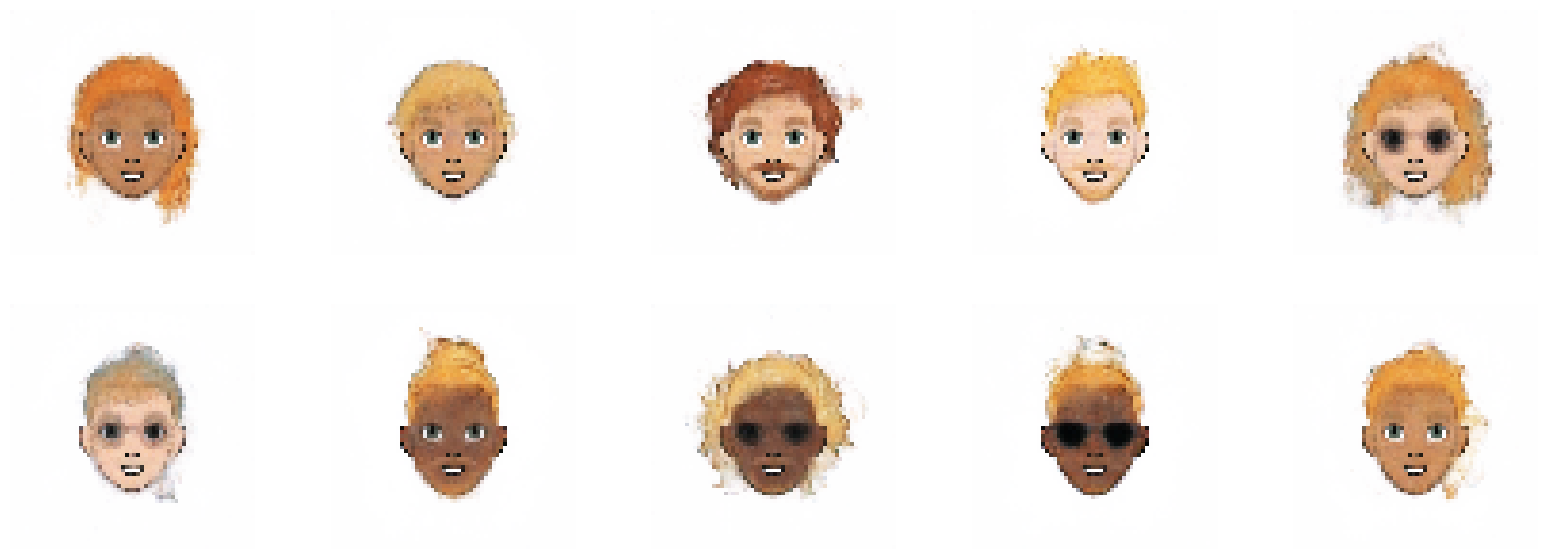

In [86]:
def generate_images(num_images=20):  # Increase number of images
    random_latent_vectors = tf.random.normal(shape=(num_images, latent_dim))
    generated_images = vae.decoder(random_latent_vectors)

    plt.figure(figsize=(num_images * 2, 7))  # Adjust figure size for better visibility
    for i in range(num_images):
        plt.subplot(2, num_images // 2, i + 1)  # Arrange in multiple rows
        plt.imshow(generated_images[i])
        plt.axis("off")
    plt.show()

# Generate and display 10 images
generate_images(10)